In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
 % cd 'drive/My Drive/Project 2 - DS'

[Errno 2] No such file or directory: 'drive/My Drive/Project 2 - DS'
/content/drive/My Drive/Project 2 - DS


In [0]:
data = pd.read_csv('african_crises.csv')

In [0]:
data.head()

,case,cc3,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,1,DZA,Algeria,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,crisis
1,1,DZA,Algeria,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,no_crisis
2,1,DZA,Algeria,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,no_crisis
3,1,DZA,Algeria,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,no_crisis
4,1,DZA,Algeria,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,no_crisis


In [0]:
# Converting text of banking crisis to numbers to be used for AORF function

data['banking_crisis'] = data.banking_crisis.apply(lambda x: 1 if x == 'crisis' else 0)
data.head()

,case,cc3,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,1,DZA,Algeria,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,1
1,1,DZA,Algeria,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,0
2,1,DZA,Algeria,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,0
3,1,DZA,Algeria,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,0
4,1,DZA,Algeria,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,0


In [0]:
# Checking dataset size for each country
data.country.value_counts()

Egypt                       155
South Africa                114
Zimbabwe                     90
Algeria                      85
Angola                       77
Tunisia                      75
Morocco                      75
Zambia                       72
Mauritius                    68
Kenya                        67
Ivory Coast                  63
Nigeria                      60
Central African Republic     58
Name: country, dtype: int64

In [0]:
# Analyzing the dataset to find out categorical and continuous variables
data.describe().T

,count,mean,std,min,25%,50%,75%,max
case,1059.0,35.613787,23.692402,1.000000,15.000000,38.00000,56.000000,7.000000e+01
year,1059.0,1967.767705,33.530632,1860.000000,1951.000000,1973.00000,1994.000000,2.014000e+03
systemic_crisis,1059.0,0.077432,0.267401,0.000000,0.000000,0.00000,0.000000,1.000000e+00
exch_usd,1059.0,43.140831,111.475380,0.000000,0.195350,0.86840,8.462750,7.443061e+02
domestic_debt_in_default,1059.0,0.039660,0.195251,0.000000,0.000000,0.00000,0.000000,1.000000e+00
sovereign_external_debt_default,1059.0,0.152975,0.360133,0.000000,0.000000,0.00000,0.000000,1.000000e+00
gdp_weighted_default,1059.0,0.006402,0.043572,0.000000,0.000000,0.00000,0.000000,4.000000e-01
inflation_annual_cpi,1059.0,20848.892444,675727.429176,-28.502137,2.086162,5.76233,11.644048,2.198970e+07
independence,1059.0,0.776204,0.416984,0.000000,1.000000,1.00000,1.000000,1.000000e+00
currency_crises,1059.0,0.128423,0.334718,0.000000,0.000000,0.00000,0.000000,1.000000e+00


This dataset is an unbalanced dataset as only 8.87% of the instances show that there was a banking crisis.

In [0]:
categ_cols = ['systemic_crisis', 'domestic_debt_in_default', 'sovereign_external_debt_default',
              'independence', 'currency_crises', 'inflation_crises']

cont_cols = ['exch_usd', 'gdp_weighted_default', 'inflation_annual_cpi']            

## Auto-odds ratio function for categorical variables

In [0]:
def Nij(df, col, h):
  # Nij: i at time 't' and j at time 't-h'
  T = len(df)     # total time length
  N0, N1, N00, N11, N01, N10 = np.zeros(6)
  for t in range(h, T):
    if df.loc[t,col] == 0:
      N0 += 1
      if df.loc[t-h,col] == 0: N00 += 1
      else: N01 += 1
    
    if df.loc[t,col] == 1:
      N1 += 1
      if df.loc[t-h,col] == 0: N10 += 1
      else: N11 += 1
  
  return np.array([N0, N1, N00, N11, N01, N10])

In [0]:
def AORF(h, col):
  # Paper:  https://doi.org/10.1080/02331888.2017.1421196
  N_vec = np.zeros(6) # Initializing N0, N1, N00, N11, N01, N10
  for country in data.country.unique():
    data_sub = data[data.country == country]

    arr = Nij(data, col, h)
    N_vec += arr

  N0, N1, N00, N11, N01, N10 = N_vec
  N01 = max(N01, 1)  # To avoid Dr = 0
  N10 = max(N10, 1)

  # Computing the paramters 
  Theta_hat = N00 * N11 / (N01 * N10)   # Again, equal for both i,j = 0,1 or 1,0
  w_hat = 0.5     # Since binary, both have equal contribution

  Theta_n_hat = 2 * Theta_hat * w_hat
  return np.log(Theta_n_hat)

Central African Republic has only 58 datapoints. So, the maximum lag we'll check would be for 10 days to have reasonable enough information for training

In [0]:
def AORF_analysis(col):
  aorf_h = []
  for h in range(1,10):
    aorf_h.append( AORF(h, col) )

  return aorf_h

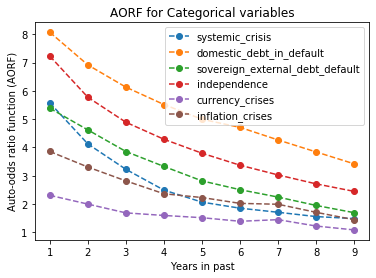

In [0]:
categ_AORF = []

for categ in categ_cols:
  categ_AORF.append( (categ, AORF_analysis(categ)) )
  
for (categ, aorf) in categ_AORF:
  plt.plot(np.arange(1,len(aorf)+1),aorf, 'o--', label=categ)

plt.xlabel('Years in past')
plt.ylabel('Auto-odds ratio function (AORF)')

plt.title('AORF for Categorical variables')
plt.legend();

The above odds ratio calculation decreases as the is high odds of getting good information from several past years decreases.

## Auto-correlation for the continuous variables

For auto-correlation, the comparison is done till the last step. Hence, Nigeria, the country with one of the least number of time-steps is plotted.

In [0]:
from pandas.plotting import autocorrelation_plot

In [0]:
cont_cols

['exch_usd', 'gdp_weighted_default', 'inflation_annual_cpi']

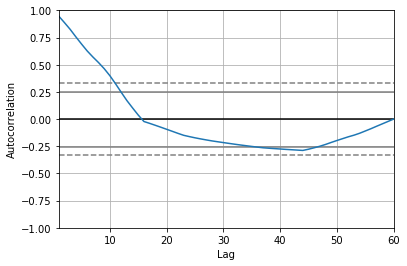

In [0]:
# exch_rate = data[data.country == 'Central African Republic']['exch_usd']
exch_rate = data[data.country == 'Nigeria']['exch_usd']

autocorrelation_plot(exch_rate)
plt.title('Auto-correlation for Exchange rate (USD)');

For `Inflation annual CPI`, the auto-correlation shows upto 11 years in the past data can be good enough.

The `gdp_weighted_default` feature has continuous values, but it has very few unique values as seen in cell below. Due to this reason, an auto-correlation for this feature doesn't make sense.

In [0]:
data['gdp_weighted_default'].unique()

array([0.  , 0.23, 0.4 , 0.13, 0.36, 0.06])

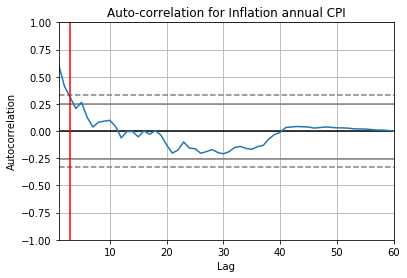

In [0]:
# inflation = data[data.country == 'Central African Republic']['inflation_annual_cpi']
inflation = data[data.country == 'Nigeria']['inflation_annual_cpi']

autocorrelation_plot(inflation)
plt.axvline(3, color='r')
plt.title('Auto-correlation for Inflation annual CPI');

For `Inflation annual CPI`, the auto-correlation shows that previous data upto 3 years in the past is a good feature.  

## Data set with lag features
Based on the above plots of auto-correlation and AORF and considering there are close to 1000 data points only, the data for 3 years in the past is selected for modeling.

In [0]:
data.drop(['case', 'cc3'], axis=1, inplace=True)
data.head()

,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,Algeria,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,1
1,Algeria,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,0
2,Algeria,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,0
3,Algeria,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,0
4,Algeria,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,0


In [0]:
countries = data.country.unique()

In [0]:
import math

for i, country in enumerate(countries):
    df_country = data[data.country == country]
    df_1 = df_country.iloc[:,2:].shift(1)  # Trimming the data to remove the first 2 columns
    df_2 = df_country.iloc[:,2:].shift(2)
    df_3 = df_country.iloc[:,2:].shift(3)

    df_23 = df_2.join(df_3, how='outer', lsuffix='_2', rsuffix='_3')
    df_01 = df_country.join(df_1, how='outer', lsuffix='', rsuffix='_1')
    df_all = df_01.join(df_23, how='outer')
    df_all = df_all.iloc[3:]  # To remove the NaN rows

    N_train = math.ceil(len(df_all)*0.8) 

    if i == 0:
        df_train = df_all.iloc[:N_train]
        df_test = df_all.iloc[N_train:]
    else:
        df_train = df_train.append(df_all.iloc[:N_train], ignore_index=True)
        df_test = df_test.append(df_all.iloc[N_train:], ignore_index=True)



In [0]:
df_train = pd.get_dummies(df_train, columns=['country'])
df_test = pd.get_dummies(df_test, columns=['country'])

In [0]:
# Saving the features with lag of 3 days in a separate csv
df_train.to_csv('Time_lag/df_train.csv', index=False)
df_test.to_csv('Time_lag/df_test.csv', index=False)